In [3]:
import numpy as np
import scipy.linalg as splin
from scipy.integrate import LSODA, solve_ivp
import matplotlib.pyplot as plt

from consts import *
from lyapunov import *
from pac import *
from potential import *
from utils import *


In [4]:
# Initial conditions (alpha0) and Jacobi interval
alpha0 = 50/384400 # initial guess for alpha

# C = 2U(r) - (vx^2 + vy^2)
C_range = [3.1370, 3.1493]

In [5]:
class Lyap_orbit:
    def __init__(self, Yd, tau, ds, mu):
        # Due to the nature of the problem, we can store only the initial conditions
        # as [x0, v0, T] for a given Lyapunov orbit and propagate them as needed
        self.Yd = Yd
        self.tau = tau
        self.ds = ds    

        # Compute the Jacobi constant
        self.C = Jacobi(np.array([Yd[0][0], 0]), np.array([0, Yd[0][1]]), mu)
    
    def toX0T(self):
        return np.array([self.Yd[0][0], 0, self.Yd[0][1], 0]), self.Yd[0][2]

    def propagate(self, n_points = 1000):
        # Initial conditions
        X0, T = self.toX0T()
        # Time span
        t_span = np.linspace(0, T, n_points)
        # Propagate the orbit
        sol = solve_ivp(fdyn, [0, T], X0, t_eval=t_span, args=(T, mu), method='LSODA')
    
        return sol




In [6]:
class lyap_family:
    def __init__(self, XL, mu, alpha0, n_orbits,
                 n_points = 1000):
        
        self.XL = XL
        self.mu = mu

        self.alpha0 = alpha0
    
        # Compute the Lyapunov orbits
        self.n_points = n_points

        # Compute the Lyapunov orbits
        self.lyap_orbits = self.compute_lyap_orbits()

In [7]:
def find_family(XL, alpha0, mu, n_orbits = 100):
    # This function computes the Lyapunov family of orbits around XL
    # Input:
    # XL: Lagrangian coordinate
    # alpha0: Initial guess for  the family
    # mu: Mass ratio
    
    family = []
    C_family = []
    tau_k = []
    ds_k = []
    
    # Start by taking the first non-linear lyapunov orbit as initial guess
    Yd0, DF, F_X = nonlin_lyapunov_orbit(XL, mu, alpha0)
    # Compute the Jacobi constant and the tangent vector
    X0 = np.array([Yd0[0][0], 0, 0, Yd0[1][0]])
    T0 = Yd0[2]

    C0 = Jacobi(X0[:2], X0[2:], mu)
    tau0 = spli.null_space(DF)
    
    family.append(Yd0)
    C_family.append(C0)
    # tau_family.append(tau0)
    # ds_family.append(1e-3)
    
    # Initialize ds
    ds = 1e-3
    i = 0 
    while i < n_orbits:
        # Try to find the next orbit
        try:
            Ydk, tauk, G_k = PAC(Yd0, tau0, ds, mu) 
            print(f"ds: {ds}, err={spli.norm(G_k)}")
            if spli.norm(G_k) < 1e-12:
                # If the norm of the constraint is below tol, we have found a new orbit
                # Append the new orbit to the family
                family.append(Ydk)
            
                C_family.append(Jacobi(np.array([Ydk[0][0], 0]), np.array([0, Ydk[1][0]]), mu))
                tau_k.append(tauk)
                ds_k.append(ds)
                # Update the initial guess for the next orbit
                Yd0 = Ydk
                tau0 = tauk

                # Update ds
                ds *= 1.2
                if ds > 0.05:
                    ds = 0.05
                
                i += 1
                print("Accepted: increasing ds")
                print(f"N of orbits: {i}")
            else:              
                ds /= 1.1
                if ds < 1e-9:
                    ds = 0.05
                print("Rejected: decreasing ds")
        except KeyboardInterrupt:
            # If keyboard interrupt, break the loop
            break       
        except:
            # If an error occurs, try to decrease ds
            ds /= 1.1
            print("Error: decreasing ds")


    return family, C_family, tau_k, ds_k





def plot_family(family: list, XL, C_family: list):
    
    # Plot orbit and color by Jacobi constant
    # Red as Cmax, blue as Cmin
    from matplotlib.colors import Normalize
    from matplotlib.cm import ScalarMappable
    
    norm = Normalize(vmin=min(C_family), vmax=max(C_family))
    cmap = plt.get_cmap('jet')  # You can choose other colormaps like 'viridis', 'plasma', etc.


    for i in range(len(family)):
        Yd = family[i]
        X, PHI = compute_orbit_Yd(Yd, mu)
        C = C_family[i]
        color = cmap(norm(C_family[i]))
        plt.plot(X[0, :], X[1, :], color=color)
    plt.axis('equal')
    # # plot moon
    plt.plot([1-mu], [0], 'ro')
    # Plot Lagrange point
    plt.plot([XL[0]], [XL[1]], 'bo')
    # Add a colorbar
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='C value', ax = plt.gca())
    
    plt.show()


In [8]:
# Find L1 family
L1_family, C1_family, L1_tau, L1_ds = find_family(XL1, alpha0, mu, n_orbits = 45)

ds: 0.001, err=9.064252828465983e-13
Accepted: increasing ds
N of orbits: 1
ds: 0.0012, err=6.907487905935532e-13
Accepted: increasing ds
N of orbits: 2
ds: 0.0014399999999999999, err=8.127914465795639e-13
Accepted: increasing ds
N of orbits: 3
ds: 0.0017279999999999997, err=9.633866717408077e-13
Accepted: increasing ds
N of orbits: 4
ds: 0.0020735999999999997, err=6.930708272643937e-13
Accepted: increasing ds
N of orbits: 5
ds: 0.0024883199999999996, err=7.81496274225701e-13
Accepted: increasing ds
N of orbits: 6
ds: 0.0029859839999999993, err=8.972412141591783e-13
Accepted: increasing ds
N of orbits: 7
ds: 0.003583180799999999, err=6.159520556646462e-13
Accepted: increasing ds
N of orbits: 8
ds: 0.0042998169599999985, err=6.752814835798682e-13
Accepted: increasing ds
N of orbits: 9
ds: 0.005159780351999998, err=7.355874362184336e-13
Accepted: increasing ds
N of orbits: 10
ds: 0.0061917364223999976, err=7.704810892369419e-13
Accepted: increasing ds
N of orbits: 11
ds: 0.00743008370687

In [9]:
# Same for L2
L2_family, C2_family, L2_tau, L2_ds = find_family(XL2, alpha0, mu, n_orbits = 50)

ds: 0.001, err=8.311078991454966e-13
Accepted: increasing ds
N of orbits: 1
ds: 0.0012, err=9.254246879090273e-13
Accepted: increasing ds
N of orbits: 2
ds: 0.0014399999999999999, err=7.44523953902401e-13
Accepted: increasing ds
N of orbits: 3
ds: 0.0017279999999999997, err=8.636746943598066e-13
Accepted: increasing ds
N of orbits: 4
ds: 0.0020735999999999997, err=9.84937863862609e-13
Accepted: increasing ds
N of orbits: 5
ds: 0.0024883199999999996, err=8.212542951001213e-13
Accepted: increasing ds
N of orbits: 6
ds: 0.0029859839999999993, err=9.345544639369905e-13
Accepted: increasing ds
N of orbits: 7
ds: 0.003583180799999999, err=7.611663773055037e-13
Accepted: increasing ds
N of orbits: 8
ds: 0.0042998169599999985, err=9.224697622781268e-13
Accepted: increasing ds
N of orbits: 9
ds: 0.005159780351999998, err=7.556770893041835e-13
Accepted: increasing ds
N of orbits: 10
ds: 0.0061917364223999976, err=9.094511255374744e-13
Accepted: increasing ds
N of orbits: 11
ds: 0.007430083706879

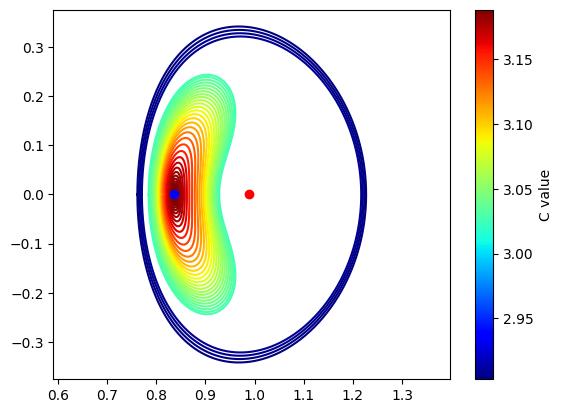

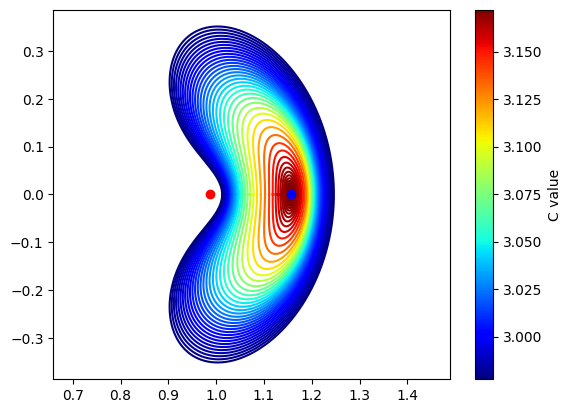

In [11]:
# Plot the faimilies of orbits side by side

plot_family(L1_family, XL1, C1_family)
plot_family(L2_family,XL2, C2_family)





In [12]:
# Then, one by one, apply the PAC around L2 and perform bisecting to find the orbit with the same Jacobi constant (Ctol = 1e-4)
Ctol = 1e-4
# Take the orbit wihtin the Jacobi constant range [C0, C1]
orbit_idx = [(i, C) for i, C in enumerate(C1_family) if C > C_range[0] and C < C_range[1]][0]



C: 3.142354906734949, err: 5.922385743136784e-13
ds: 0.011000000000000001


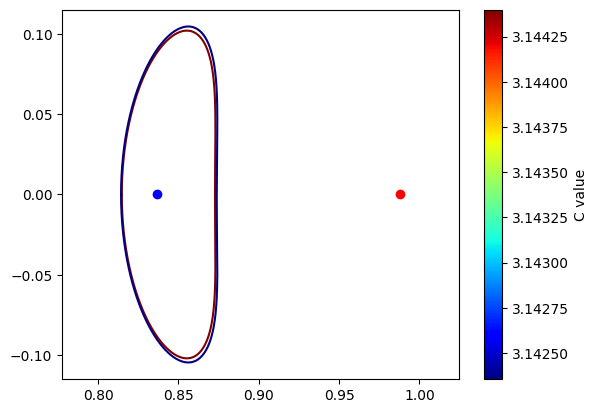

In [13]:


# Parent orbit 
Yd_parent = L1_family[orbit_idx[0]]
tau_parent = L1_tau[orbit_idx[0]]
C_parent = C1_family[orbit_idx[0]]

# Inialize the orbit
Yd_temp = L1_family[orbit_idx[0]]
C_temp = C1_family[orbit_idx[0]]
tau_temp = L1_tau[orbit_idx[0]]

G_guess = 1
C_guess = 0
ds = 1e-2

while spli.norm(G_guess) > 1e-12 and not(C_guess > C_range[0] and C_guess < C_range[1]):
    Yd_temp1, tau_temp1, G_guess = PAC(Yd_temp, tau_temp, ds, mu)
    
    Yd_temp = Yd_temp1
    tau_temp = tau_temp1
    C_guess = Jacobi(np.array([Yd_temp[0][0], 0]), np.array([0, Yd_temp[1][0]]), mu)
    print(f"C: {C_guess}, err: {spli.norm(G_guess)}")
    if C_guess < C_range[0]:
        ds /= 1.1
    elif C_guess > C_range[1]:
        ds /= 1.1
    else:
        ds *= 1.1
    print(f"ds: {ds}")

# Create a list with the two orbits and their Jacobi constants
L1_target = [Yd_parent, Yd_temp]
C1_target = [C_parent, C_guess]

# Plot the orbits
plot_family(L1_target, XL1, C1_target)


In [ ]:
L2_target = []  # List to store the orbits
C2_target = []  # List to store the Jacobi constants

In [ ]:
C_target = C1_target[0]
idx = 0
for i in range(len(C2_family)):
    if C2_family[i] < C_target and C2_family[i-1] > C_target:
        # idx is the lower than orbit, while idx-1 is the higher than orbit
        print(f"Range: {C2_family[i-1]} - {C2_family[i]}")

        idx = i
        break

x_a = L2_family[idx-1][0][0]
print(f"C:{C2_family[idx-1]}")
x_b = L2_family[idx][0][0]


# Inialize the orbit
Yd_temp = L2_family[idx-1]
C_temp = C2_family[idx-1]
tau_temp = L2_tau[idx-1]
ds = L2_ds[idx-1]/2

G_guess = 1
print(f"Target: {C_target}")

C_guess = 0

while spli.norm(G_guess) > 1e-12  or abs(C_guess - C_target) > 1e-5:
    Yd_temp, tau_temp, G_guess = PAC(Yd_temp, tau_temp, ds, mu)
    

    C_guess = Jacobi(np.array([Yd_temp[0][0], 0]), np.array([0, Yd_temp[1][0]]), mu)
    
    if C_guess < C_target:
        ds /= -1.1
    elif C_guess > C_target:
        if np.sign(ds) < 0:
            ds = -ds
        ds /= 1.1
    else:
        ds *= 1.1
    print(f"ds: {ds}, C: {C_guess}, err: = {abs(C_guess - C_target)}")

print(f"Final C: {C_guess}, err: = {abs(C_guess - C_target)}")

L2_target.append(Yd_temp)
C2_target.append(C_guess)





Range: 3.149954286405359 - 3.1419320223668907
C:3.149954286405359
Target: 3.144399216220354
ds: 0.017426181783852145, C: 3.146079845749287, err: = 0.0016806295289328865
ds: -0.015841983439865585, C: 3.142379295520023, err: = 0.0020199207003308572
ds: 0.014401803127150531, C: 3.14573148222578, err: = 0.0013322660054257973
ds: -0.013092548297409572, C: 3.142673515125386, err: = 0.0017257010949678353
ds: 0.011902316634008701, C: 3.1454452628204748, err: = 0.0010460466001207536
ds: -0.010820287849098819, C: 3.142918331626552, err: = 0.0014808845938021342
ds: 0.009836625317362561, C: 3.145209892892831, err: = 0.0008106766724771397
ds: -0.008942386652147782, C: 3.1431217811616956, err: = 0.001277435058658405
ds: 0.008129442411043438, C: 3.145016188272258, err: = 0.000616972051903808
ds: -0.00739040219185767, C: 3.143290680543864, err: = 0.0011085356764901633
ds: 0.006718547447143336, C: 3.144856666486793, err: = 0.0004574502664391744
ds: -0.006107770406493942, C: 3.1434307813304496, err: = 0

In [ ]:
# Do the same for the other orbit
C_target = C1_target[1]
idx = 0
for i in range(len(C2_family)):
    if C2_family[i] < C_target and C2_family[i-1] > C_target:
        # idx is the lower than orbit, while idx-1 is the higher than orbit
        print(f"Range: {C2_family[i-1]} - {C2_family[i]}")

        idx = i
        break

x_a = L2_family[idx-1][0][0]
print(f"C:{C2_family[idx-1]}")
x_b = L2_family[idx][0][0]


# Inialize the orbit
Yd_temp = L2_family[idx-1]
C_temp = C2_family[idx-1]
tau_temp = L2_tau[idx-1]
ds = L2_ds[idx-1]/2

G_guess = 1
print(f"Target: {C_target}")

C_guess = 0

while spli.norm(G_guess) > 1e-12  or abs(C_guess - C_target) > 1e-4:
    Yd_temp, tau_temp, G_guess = PAC(Yd_temp, tau_temp, ds, mu)
    

    C_guess = Jacobi(np.array([Yd_temp[0][0], 0]), np.array([0, Yd_temp[1][0]]), mu)
    
    if C_guess < C_target:
        ds /= -1.1
    elif C_guess > C_target:
        if np.sign(ds) < 0:
            ds = -ds
        ds /= 1.1
    else:
        ds *= 1.1
    print(f"ds: {ds}, C: {C_guess}, err: = {abs(C_guess - C_target)}")

print(f"Final C: {C_guess}, err: = {abs(C_guess - C_target)}")

L2_target.append(Yd_temp)
C2_target.append(C_guess)







Range: 3.149954286405359 - 3.1419320223668907
C:3.149954286405359
Target: 3.142354906734949
ds: 0.017426181783852145, C: 3.146079845749287, err: = 0.0037249390143379024
ds: 0.015841983439865585, C: 3.142379295520023, err: = 2.4388785074158648e-05
Final C: 3.142379295520023, err: = 2.4388785074158648e-05


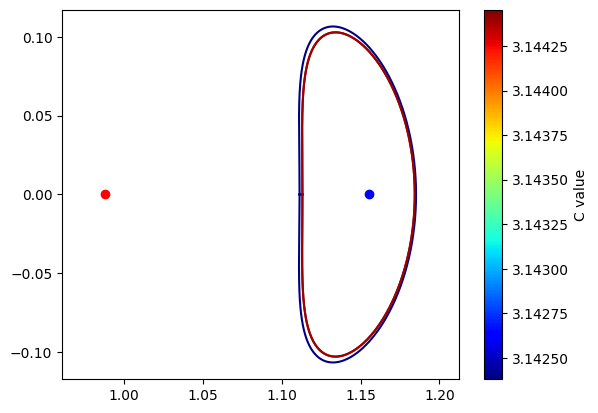

In [ ]:
plot_family(L2_target, XL2, C2_target)

In [ ]:
# Now L1_family contains the two orbits with the same Jacobi constant as L2_family
